[![Abrir no Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tmelo-uea/opinion-mining/blob/master/Mineracao_Opiniao_Ocean.ipynb)


#Scikit-Learn



*   É considerada como a biblitoca de Python mais utilizada para a implementação de métodos baseados em algoritmos de aprendizagem de máquina (*machine learning*).
* A versão atual é a 1.5.0 (maio 2024).
*   URL: http://scikit-learn.org



#Formulação do Problema



*   Problema de classificação **supervisionada** de texto.
*   Hoje iremos investigar o método de aprendizagem de máquina que seja mais apropriado para resolvê-lo.
* Considere um site de notícias que publica matérias jornalísticas de vários temas.
* Economia, saúde e esportes são exemplos de temas.
* O objetivo é criar um método classificador que receba um texto de entrada e consiga identificar qual é o assunto do texto.
* O classificador assume que cada texto está associado a um tema.
* É um problema de classificação de texto multiclasses.


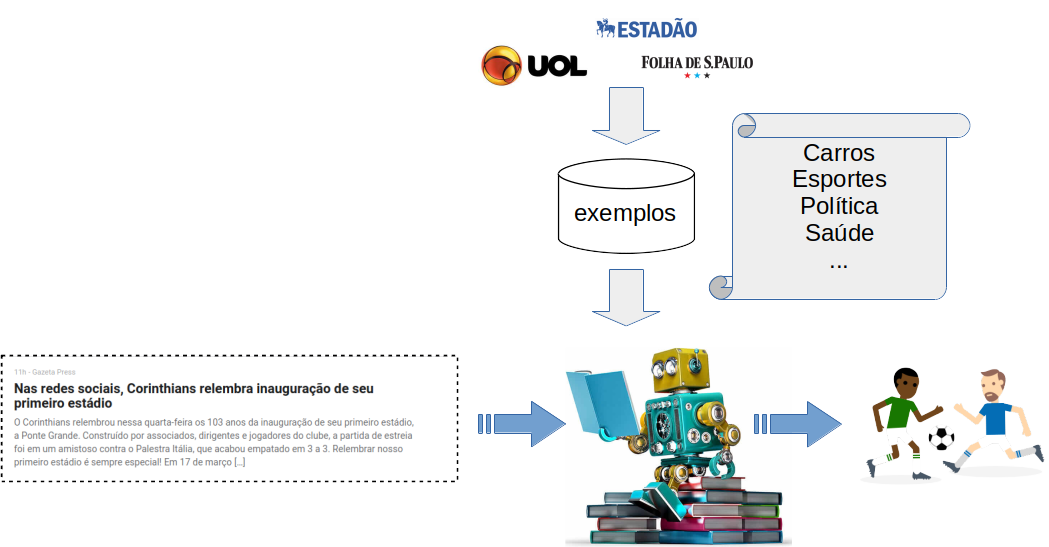

# Exploração dos Dados

### Carregar *dataset*

In [ ]:
import pandas as pd
import requests
from io import StringIO

In [ ]:
url = "http://tiagodemelo.info/datasets/dataset-uol.csv"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0"}
req = requests.get(url, headers=headers)
data = StringIO(req.text)

df = pd.read_csv(data)

In [ ]:
df.shape

(518227, 2)

In [ ]:
df.CATEGORIA.unique()

array(['coronavirus', 'politica', 'esporte', 'carro', 'educacao',
       'entretenimento', 'economia', 'saude'], dtype=object)

### Verificar dados nulos (NaN)

In [ ]:
df.isnull().any()

,0
CATEGORIA,False
TEXTO,True


In [ ]:
df.isnull().sum()

,0
CATEGORIA,0
TEXTO,13451


In [ ]:
index_with_nan = df.index[df.isnull().any(axis=1)]
index_with_nan.shape
df.drop(index_with_nan, axis=0, inplace=True)

In [ ]:
df.shape

(504776, 2)

### Adicionar coluna ao *dataset*

In [ ]:
ids_categoria = df['CATEGORIA'].factorize()[0]
df['ID_CATEGORIA'] = ids_categoria

In [ ]:
df.head(n=10)

,CATEGORIA,TEXTO,ID_CATEGORIA
0,coronavirus,"Na manhÃ£ de ontem, o chefe do Executivo receb...",0
1,coronavirus,Os parentes acreditaram que os dois pudessem e...,0
2,politica,28.jan.2020 - Equipe mÃ©dica embarca rumo a Wu...,1
3,esporte,A estratÃ©gia serve para o Alviverde melhorar ...,2
4,coronavirus,31.jan.2020 - TripulaÃ§Ã£o embarca em voo com ...,0
5,coronavirus,"Especialistas em saÃºde foram afastados, segun...",0
6,carro,"Por exemplo, prazer ao dirigir Ã© algo que eu ...",3
7,educacao,8) Calcular a Ã¡rea do setor circular com Ã¢ng...,4
8,coronavirus,Engano. Se chega ao pico da curva quando + 60%...,0
9,coronavirus,"""Ã cruel pensar assim, mas se eu tivesse a le...",0


In [ ]:
df.ID_CATEGORIA.unique()

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
column_values = df[["ID_CATEGORIA", "CATEGORIA"]].values.ravel()
unique_values = pd.unique(column_values)
print(unique_values)

[0 'coronavirus' 1 'politica' 2 'esporte' 3 'carro' 4 'educacao' 5
 'entretenimento' 6 'economia' 7 'saude']


In [ ]:
category_id_df = df[['CATEGORIA', 'ID_CATEGORIA']].drop_duplicates().sort_values('ID_CATEGORIA')
id_to_category = dict(category_id_df[['ID_CATEGORIA', 'CATEGORIA']].values)
id_to_category

{0: 'coronavirus',
 1: 'politica',
 2: 'esporte',
 3: 'carro',
 4: 'educacao',
 5: 'entretenimento',
 6: 'economia',
 7: 'saude'}

### Distribuição das notícias entre as categorias

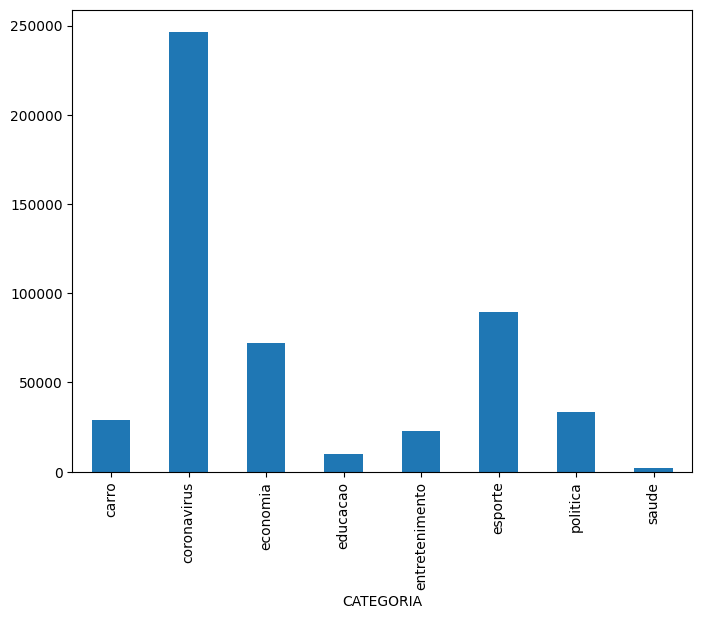

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,6))

df.groupby('CATEGORIA').TEXTO.count().plot.bar()
plt.show()



*   Um problema recorrente é o **desbalanceamento das classes**.
*   Os algoritmos convencionais tendem a favorecer as classes mais frequentes, ou seja, não consideram as classes menos frequentes.
*  As classes menos frequentes costumam ser tratadas como *outliers*.
* Estratégias de *undersampling* ou *oversampling* são aplicadas para tratar desse problema [[1]](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis).
* Lidar com essas estratégias será discutido posteriormente.




#### Preparar dataset para que todas as categorias tenham a mesma quantidade de publicações

In [ ]:
TAMANHO_DATASET = 200 #quantidade de artigos por classe.

In [ ]:
categorias = list(set(df['ID_CATEGORIA']))

data = []
for cat in categorias:
  total = TAMANHO_DATASET
  for c,t,i in zip(df['CATEGORIA'], df['TEXTO'], df['ID_CATEGORIA']):
    if total>0 and cat == i:
      total-=1
      data.append([c,t,i])

df = pd.DataFrame(data, columns=['CATEGORIA','TEXTO','ID_CATEGORIA'])

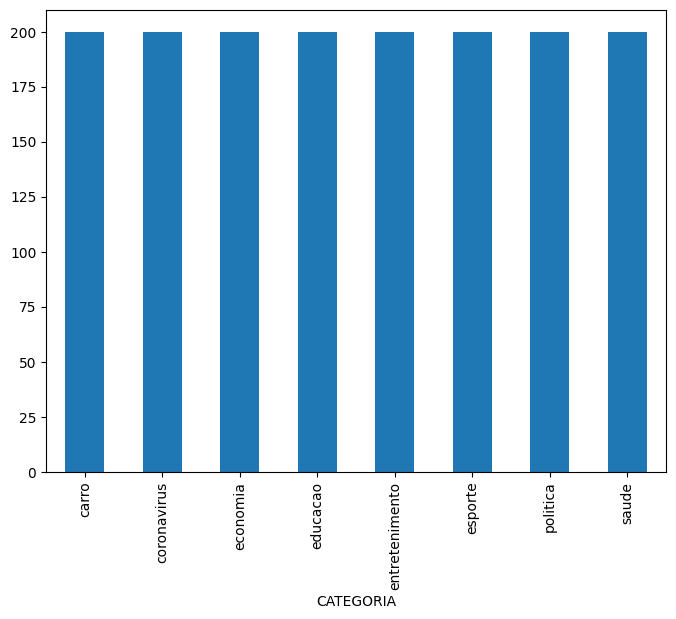

In [ ]:
fig = plt.figure(figsize=(8,6))

df.groupby('CATEGORIA').TEXTO.count().plot.bar(ylim=0)
plt.show()

# Representação do Texto



*   Os métodos de aprendizagem de máquina lidam melhor com representações numéricas ao invés de representação textual.
*   Portanto, os textos precisam ser convertidos.
* *Bag of words* é uma forma comum de representar os textos.
* Nós vamos calcular a medida de *Term Frequency* e *Inverse Document Frequency*, abreviada como **TF-IFD**.
* Nós usaremos o `sklearn.feature_extraction.text.TfidfVectorizer` para calcular o `tf-idf`.



## *Bag of Words*

É uma representação de texto comumente usada em problemas relacionados com processamento de linguagem natural e recuperação da informação.

sentença 1: "Os brasileiros gostam de futebol"

sentença 2: "Os americanos adoram futebol e adoram basquete"

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
from nltk.tokenize import word_tokenize

sentenca1 = "Os brasileiros gostam de futebol"
sentenca2 = "Os americanos adoram futebol e adoram basquete"

texto1 = word_tokenize(sentenca1)
texto2 = word_tokenize(sentenca2)

print (texto1)
print (texto2)

['Os', 'brasileiros', 'gostam', 'de', 'futebol']
['Os', 'americanos', 'adoram', 'futebol', 'e', 'adoram', 'basquete']


In [ ]:
from nltk.probability import FreqDist

fdist1 = FreqDist(texto1)
fdist2 = FreqDist(texto2)

print(fdist1.most_common())
print(fdist2.most_common())

[('Os', 1), ('brasileiros', 1), ('gostam', 1), ('de', 1), ('futebol', 1)]
[('adoram', 2), ('Os', 1), ('americanos', 1), ('futebol', 1), ('e', 1), ('basquete', 1)]


In [ ]:
texto = texto1 + texto2
fdist = FreqDist(texto)
print(fdist.most_common())

[('Os', 2), ('futebol', 2), ('adoram', 2), ('brasileiros', 1), ('gostam', 1), ('de', 1), ('americanos', 1), ('e', 1), ('basquete', 1)]


sentença 1: "Os brasileiros gostam de futebol"

sentença 2: "Os americanos adoram futebol e adoram basquete"





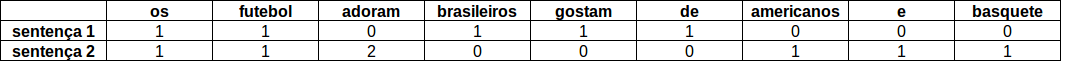

Sentença 1: [1 1 0 1 1 1 0 0 0]

Sentença 2: [1 1 2 0 0 0 1 1 1]

## TF-IDF

TF representa a frequência do termo.

IDF representa o inverso da frequência nos documentos.

##Texto no SKLearn

Opções (paramêtros) utilizados:

*   `min_df` é o número mínimo de documentos que uma palavra deve estar presente.
* `encoding` é usado para que o classificador consiga lidar com caracteres especiais.
*   `ngram_range` é definida para considerar unigramas e bigramas.
* `stop_words` é definida para reduzir o número de termos indesejáveis.




In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tfidf = TfidfVectorizer(min_df=5, encoding='latin-1', ngram_range=(1, 2), stop_words=stopwords.words('portuguese'))

features = tfidf.fit_transform(df.TEXTO.values.astype('U')).toarray()
labels = df.ID_CATEGORIA
features.shape

(1600, 2044)

#Criação de Classificador

Importar bibliotecas:

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

Dividir *dataset* em **treino** e **teste**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['TEXTO'], df['CATEGORIA'], test_size=0.2, random_state = 0)

Criar um modelo (Naive Bayes)

In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train.values.astype('U'))
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

Testar o classificador criado:

In [ ]:
sentenca = 'Os estudantes de engenharia demoram o dobro tempo na faculdade.'
print(clf.predict(count_vect.transform([sentenca])))

['esporte']


#Seleção do Modelo

Nós agora vamos experimentar diferentes modelos de aprendizagem de máquina e avaliar a sua acurácia.

Serão considerados os seguintes modelos:
*   Logistic Regression (LR)
*   Multinomial Naive Bayes (NB)
*   Linear Support Vector Machine (SVM)
*   Random Forest (RF)



Importar bibliotecas:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

Lista com os modelos:

In [ ]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=None, tol=0.0001, verbose=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

## Validação Cruzada

A validação cruzada é um método de reamostragem e tem como objetivo avaliar a capacidade de **generalização** do modelo.

Normalmente a distribuição entre treino e teste é feita da seguinte forma:

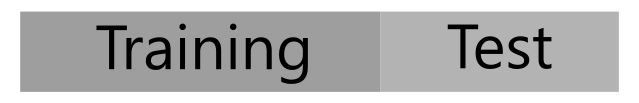

Na validação cruzada:

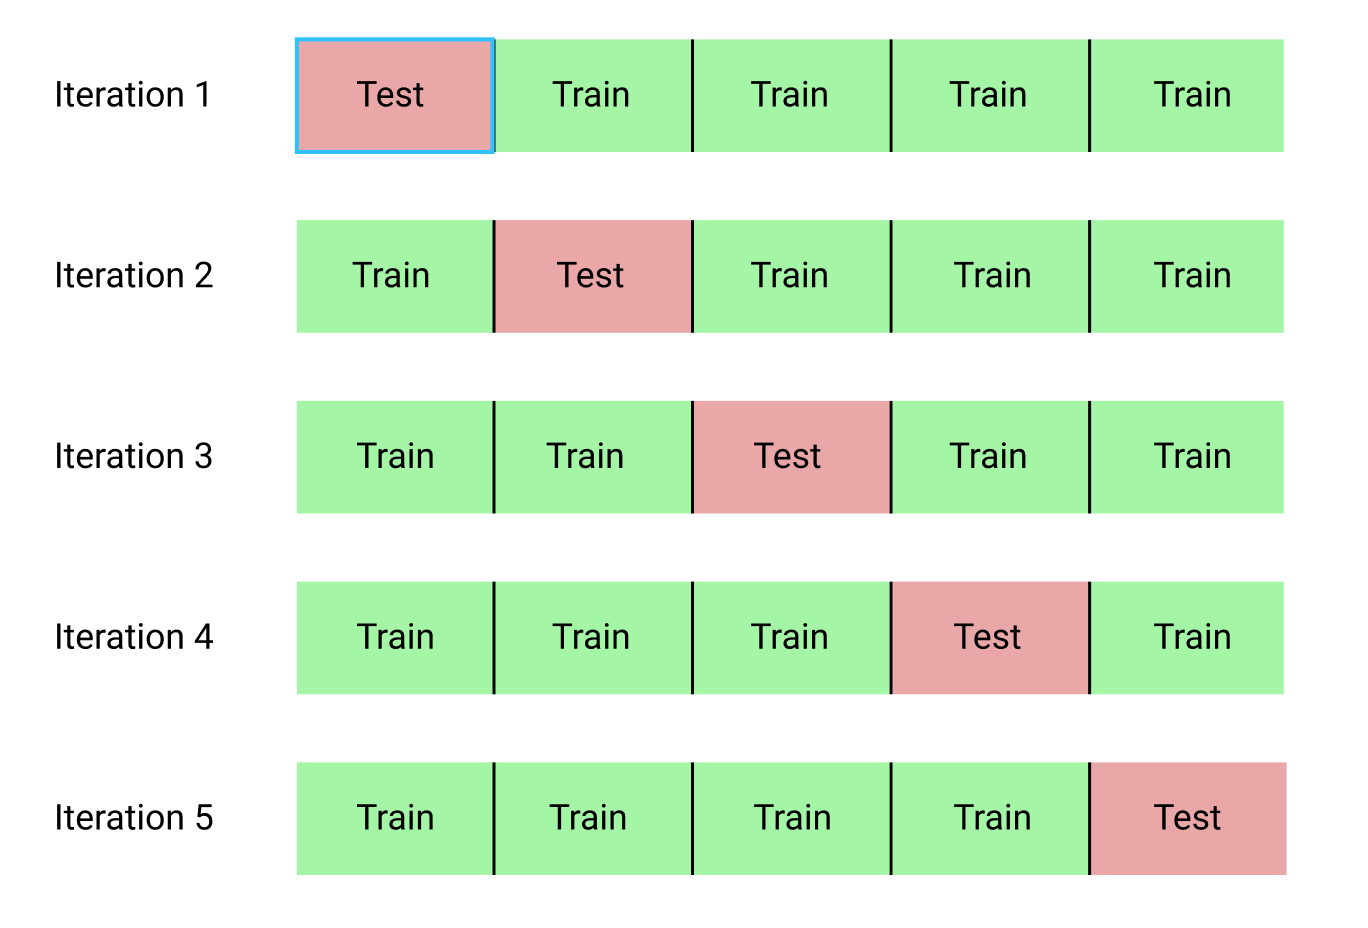

Uso de validação cruzada com 5 *folds*:

In [ ]:
CV = 5

Geração dos modelos:

In [ ]:
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

## Gráfico BoxPlot

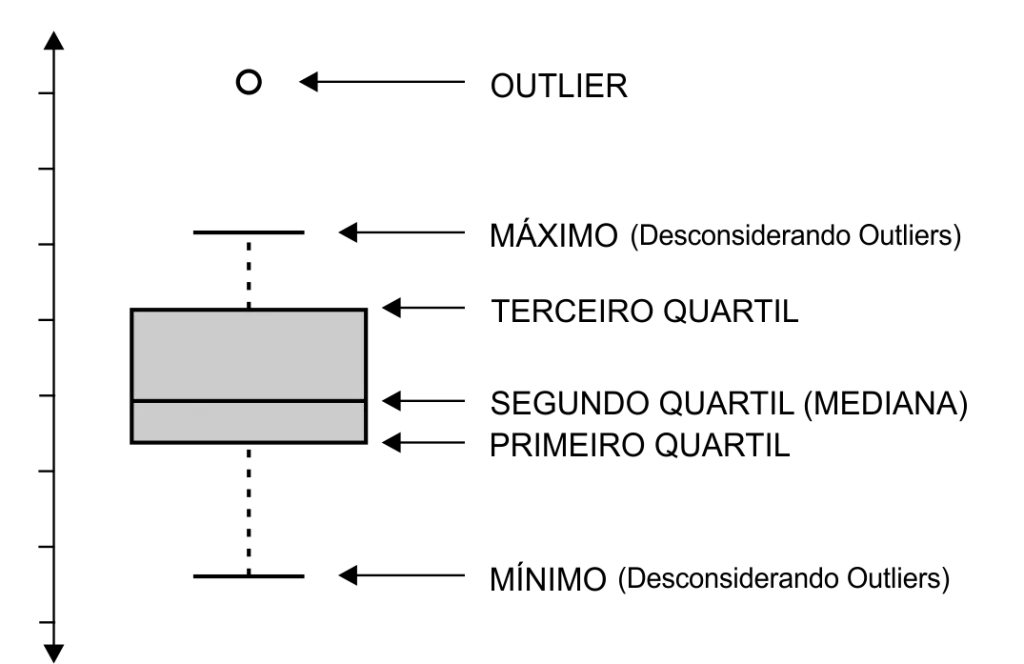

Plotar o gráfico comparativo:

<ipython-input-72-45d0b4bafde1>:4: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


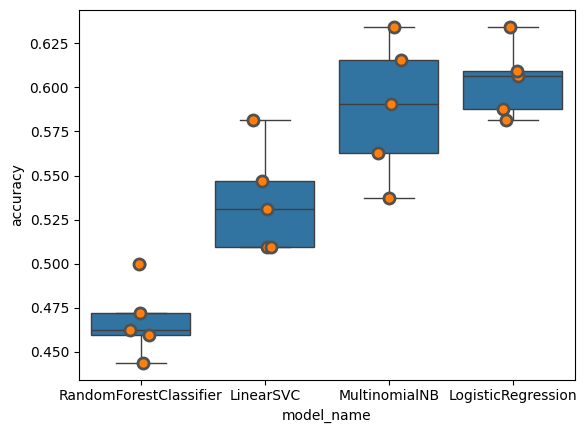

In [ ]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()

Acurácia média entre os 5 modelos:

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

,accuracy
model_name,
LinearSVC,0.535625
LogisticRegression,0.603750
MultinomialNB,0.588125
RandomForestClassifier,0.467500


# Matriz de Confusão

Geração de modelo baseado em SVM:

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Plotar matriz de confusão para o modelo SVM:

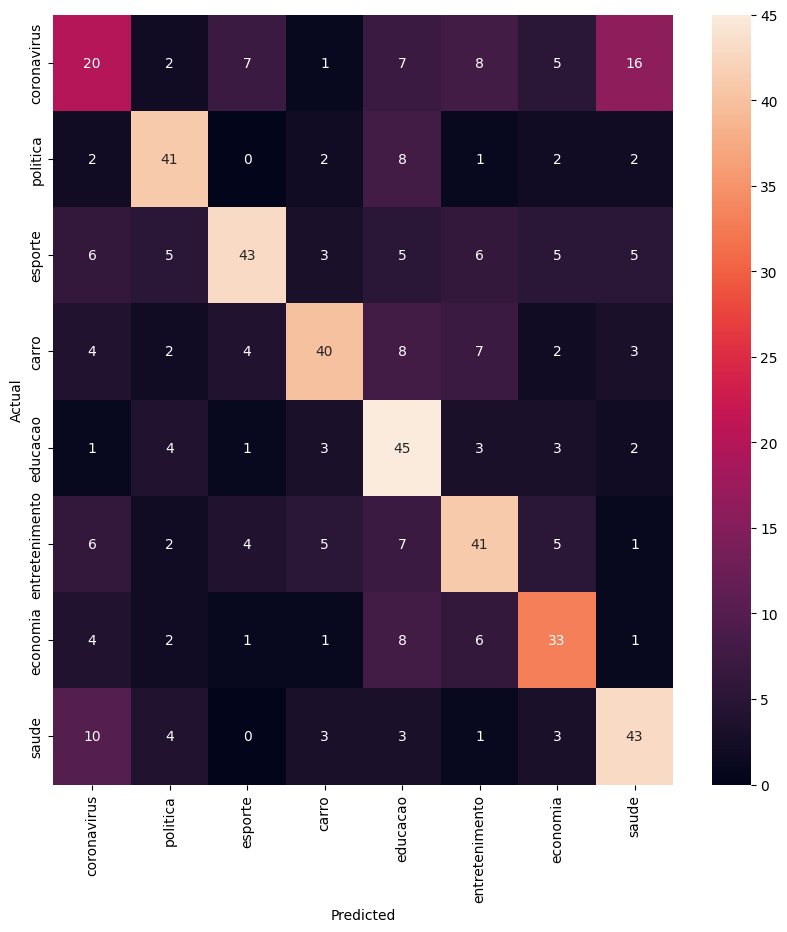

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.CATEGORIA.values, yticklabels=category_id_df.CATEGORIA.values)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

Reportar o resultado do classificador em cada classe:

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_test, y_pred, target_names=df['CATEGORIA'].unique()))

                precision    recall  f1-score   support

   coronavirus       0.38      0.30      0.34        66
      politica       0.66      0.71      0.68        58
       esporte       0.72      0.55      0.62        78
         carro       0.69      0.57      0.62        70
      educacao       0.49      0.73      0.59        62
entretenimento       0.56      0.58      0.57        71
      economia       0.57      0.59      0.58        56
         saude       0.59      0.64      0.61        67

      accuracy                           0.58       528
     macro avg       0.58      0.58      0.58       528
  weighted avg       0.59      0.58      0.58       528



# Exercícios propostos

*   Nós usamos acurácia como métrica para avaliar os quatro modelos de classificação de texto. Execute novamente o notebook, mas agora usando a métrica F1 e analise os resultados.
*   Pesquise outros modelos de classificação de texto que estão disponíveis no Scikit-Learn e inclua nos experimentos.
*   Execute novamente o notebook, mas agora utilize todo o conjunto de dados (*dataset*). Observe que as classes estarão desbalanceadas. Avalie e compare o resultado com os classificadores treinados em classes balanceadas.
*   Os modelos estão configurados com um conjunto pré-definido de hiperparâmetros. Pesquise e experimente outras possíveis combinações de hiperparâmetros para os modelos e avalie se os resultados irão melhorar. Sugestão: pesquise estratégias como GridSearchCV e RandomizedSearchCV em [LINK](https://scikit-learn.org/stable/modules/grid_search.html#).
*   Pesquise, proponha e experimente outras estratégias para tentar melhorar o resultado alcançado pelos modelos propostos.

